In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import scvelo as scv

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\pipeline_control'

In [6]:
Path(notebook_dir).parents[1]

WindowsPath('c:/Users/OmerCagatayTalikaci/Desktop/github/STVelo')

In [7]:
os.chdir(Path(notebook_dir).parents[1])

In [13]:
import sys  
sys.path.insert(1,'c:/Users/OmerCagatayTalikaci/Desktop/github/STVelo/stvelo')

In [14]:
from pipelines.simulate_3ode import *

# Simulation

In [15]:
mu = np.array([3, 1.8, 0.8, 0.5])

R = np.array([[.16, .128, .08, .032],
              [.128, .16 , .08, .032],
              [.08, .08, .16 , .08],
              [.032 ,.032 , .08 , .16]])

C = np.array([0.4, 0.4, 0.4, 0.4])[:, None]

cov = C * R
cov=np.log(cov)
alpha, beta , nu, gamma = np.exp(np.random.multivariate_normal(mu, cov, size = 300).T)

In [16]:
def switch_times(t_max, n_vars):
    lower_bound = 0.05 * t_max
    upper_bound = 0.8 * t_max

    
    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [17]:
s = switch_times(20,300)

In [18]:
adata_dict = simulation_3ode(n_obs=800,alpha=alpha, beta= beta, nu=nu, gamma=gamma, t_max=20, switches=s/20,n_vars=300)

In [19]:
adata_dict

{'adata_s_u': AnnData object with n_obs × n_vars = 800 × 300
     obs: 'true_t'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
     layers: 'unspliced', 'spliced',
 'adata_n_c': AnnData object with n_obs × n_vars = 800 × 300
     obs: 'true_t'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling'
     layers: 'unspliced', 'spliced'}

# Preprocessing

In [20]:
from pipelines.preprocessing import Preprocessing

In [21]:
config = {
'preprocess_params': {
    'min_counts': 200,
    'min_cells': 5,
    'n_neighbors': 23,
    'n_pcs': 0,
    'min_dist': 1,
    # 'resolution': 0.8
},
'functions_to_apply': {
    'filter_cells': True,
    'filter_genes': True,
    'normalize_total': True,
    'log1p': True,
    'pca': True,
    'neighbors': True,
    'umap': True,
    'leiden': True,
    'moments': True
}
}

In [22]:
for key, adata in adata_dict.items():
    print(f'{key} is being preprocessed.')
    preprocessor = Preprocessing(adata,config)
    adata = preprocessor.preprocess_data()

adata_s_u is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
adata_n_c is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [23]:
adata_dict

{'adata_s_u': AnnData object with n_obs × n_vars = 799 × 300
     obs: 'true_t', 'n_counts', 'leiden'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'unspliced', 'spliced', 'Ms', 'Mu'
     obsp: 'distances', 'connectivities',
 'adata_n_c': AnnData object with n_obs × n_vars = 799 × 300
     obs: 'true_t', 'n_counts', 'leiden'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'unspliced', 'spliced', 'Ms', 'Mu'
     obsp: 'distances', 'connectivities'}

# Velocities

In [26]:
from pipelines.compute_velocity import Velocities

In [ ]:
# config = {
#     'velocity_types': ['deterministic', 'stochastic', 'dynamical', 'velovi']
# }

In [27]:
config = {
    'velocity_types': ['dynamical', 'velovi']
}

In [28]:
velocity_computer = Velocities(adata_dict,config)

Using device: cuda


In [29]:
adata_dict_velocity = velocity_computer.compute_velocities()

recovering dynamics (using 8/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:19) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
min_max_scaler is working!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 8GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:11<00:00, 12.42it/s, v_num=1, train_loss_step=-314, train_loss_epoch=-292]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s, v_num=1, train_loss_step=-314, train_loss_epoch=-292]
recovering dynamics (using 8/24 cores)
    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
min_max_scaler is working!
Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 11.74it/s, v_num=1, train_loss_step=-274, train_loss_epoch=-281]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:08<00:00, 11.34it/s, v_num=1, train_loss_step=-274, train_loss_epoch=-281]


In [30]:
adata_dict_velocity

{'adata_s_u_dynamical': AnnData object with n_obs × n_vars = 799 × 300
     obs: 'true_t', 'n_counts', 'leiden', 'velocity_self_transition'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gamma', 'true_scaling', 'n_cells', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
     uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs', 'loss'
     layers: 'unspliced', 'spliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
     obsp: 'distances', 'connectivities',
 'adata_s_u_velovi': AnnData object with n_obs × n_vars = 799 × 213
     obs: 'true_t', 'n_counts', 'leiden'
     var: 'true_t_', 'true_alpha', 'true_beta', 'true_nu', 'true_gam

In [31]:
scv.tl.velocity_graph(adata_dict_velocity['adata_n_c_velovi'])

computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


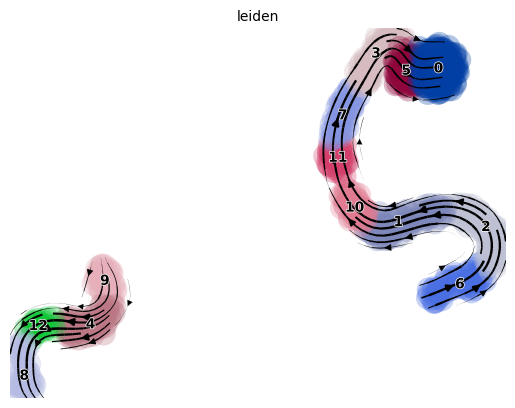

In [32]:
scv.pl.velocity_embedding_stream(adata_dict_velocity['adata_n_c_velovi'], basis='umap',color='leiden')